<a href="https://colab.research.google.com/github/Geetha495/Diffusion-model/blob/main/Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

In [ ]:
device = torch.device("cuda:0")

### Data loading

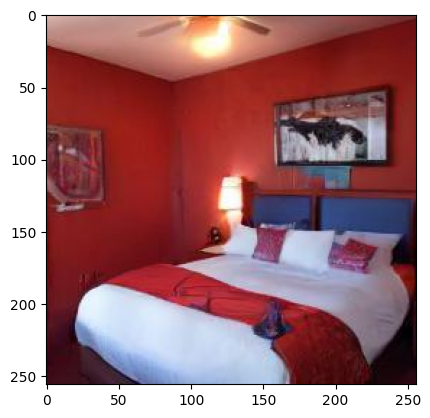

In [ ]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://drive.google.com/uc?export=download&id=1cswWOA9mdLDm_4mqS9s1vvEbzpAJu3WF'
    filename = 'bedroom.png'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

# Display image
img = get_sample_image()
plt.imshow(img)

### Plotting Noise distrubtuion, images

In [ ]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

def plot_noise_image(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

## Diffusion Model
### Defining a schedule
The diffusion process is built based on a variance schedule, which determines the levels of added noise at each step of the process. To that end, our schedule is defined below, with the following quantities:

* `betas`:$\beta_t$

* `alphas`: $\alpha_t=1-\beta_t$

* `alphas_cumprod`: $\bar{\alpha}_t=\prod_{i=0}^{t}\alpha_i$

### Forward Process
The forward process $q$ determines how subsequent steps in the diffusion are derived (gradual distortion of the original sample $x_0$).


Basic format of the forward step:
$$q(x_t|x_{t−1}) := \mathcal{N}(x_t; \sqrt{1 − \beta_t}x_{t−1}, \beta_tI) \tag{1}$$

to step directly from $x_0$ to $x_t$:
$$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0, (1 − \bar{\alpha_t})I) \tag{2}$$

### Reverse Process

The purpose of the reverse process $p$ is to approximate the previous step $x_{t-1}$ in the diffusion chain based on a sample $x_t$. A parametrizable prediction model with parameters $\theta$ is used to estimate $p_\theta(x_{t-1}|x_t)$.

The reverse process will also be (approximately) gaussian if the diffusion steps are small enough:

$$p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mu_\theta(x_t),\Sigma_\theta(x_t))\tag{3}$$

In many works, it is assumed that the variance of this distribution should not depend strongly on $x_0$ or $x_t$, but rather on the stage of the diffusion process $t$. This can be observed in the true distribution $q(x_{t-1}|x_t, x_0)$, where the variance of the distribution equals $\tilde{\beta}_t$.

* $\mu_\theta(x_t)$ is calculted as a function of $\epsilon_θ(x_t, t)$ using below formula
$$
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta} (x_t, t) \right)
$$

where $\epsilon_θ(x_t, t)$ is an U-Net Model

In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [ ]:
IMAGE_SHAPE = (32, 32)

The majority of the diffusion models assume that the images are scaled to the `[-1,+1]` range (which tends to simplify many equations)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])


In [ ]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [ ]:
diffusion_model = DiffusionModel()

## Forward process

<Figure size 1500x1500 with 0 Axes>

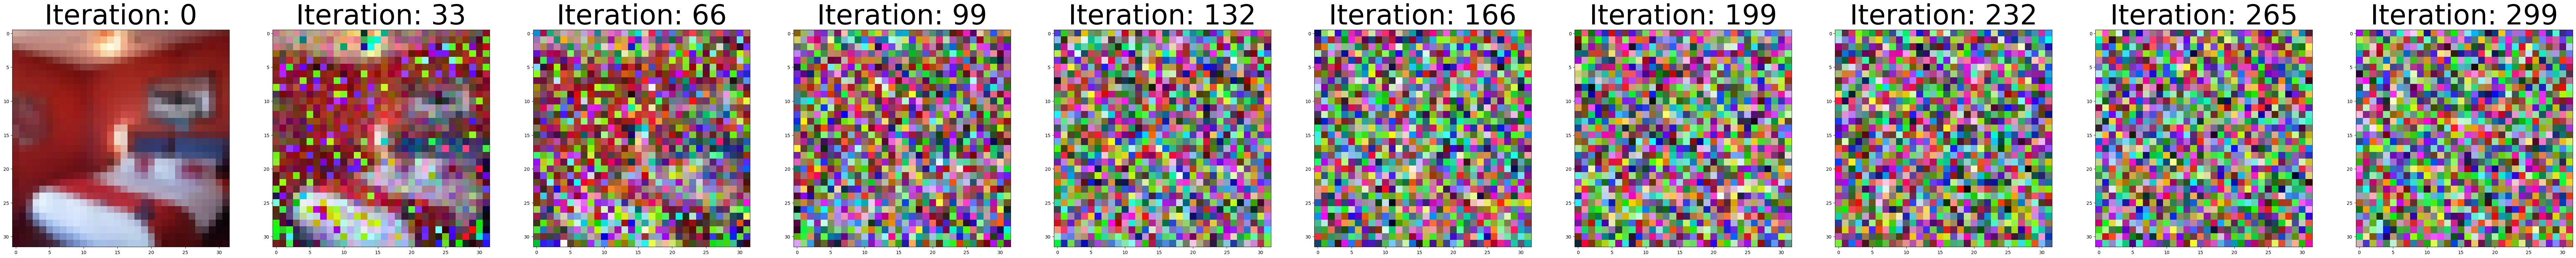

In [ ]:
NO_DISPLAY_IMAGES = 10
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 60)
plt.show()


Sinusoidal postion embeddings ( same as those of "Attention is all you need" )
$$
\begin{align}
        PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
\end{align}
$$

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        '''
            e^{i*-log(1000)/(d-1)} = 1/[ (e^log(1000))^(i/(d-1)) ]
                                   = 1/[ 1000^{i/(d-1)} ]
        '''
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

## UNET Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [ ]:
NO_EPOCHS = 1000
PRINT_FREQUENCY = 250
LR = 0.0005
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

## Training

---
Epoch: 0 | Train Loss 1.0305118560791016


<Figure size 1500x1500 with 0 Axes>

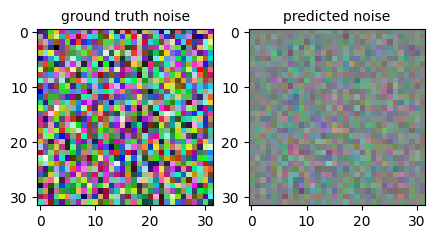

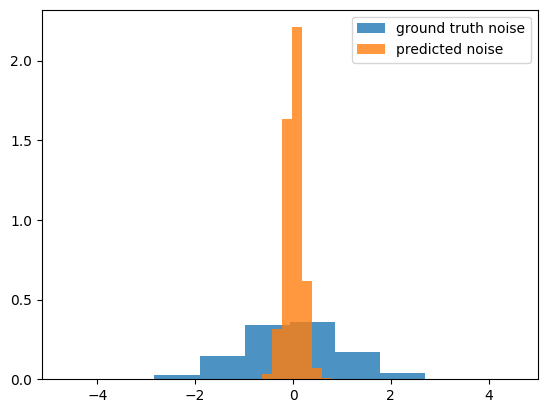

---
Epoch: 250 | Train Loss 0.02686278522014618


<Figure size 1500x1500 with 0 Axes>

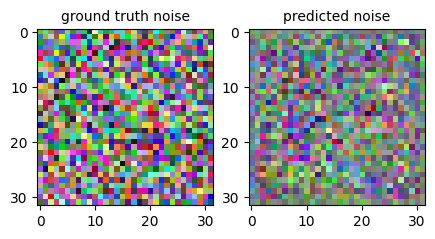

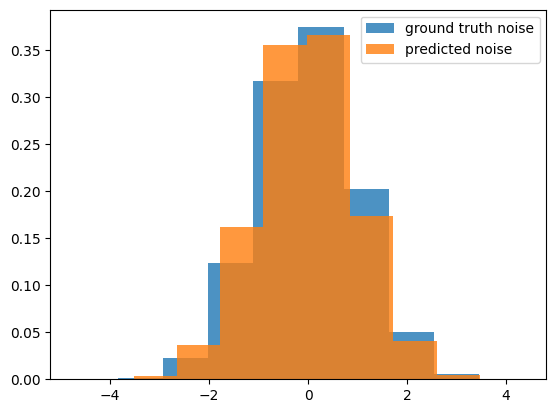

---
Epoch: 500 | Train Loss 0.020248770713806152


<Figure size 1500x1500 with 0 Axes>

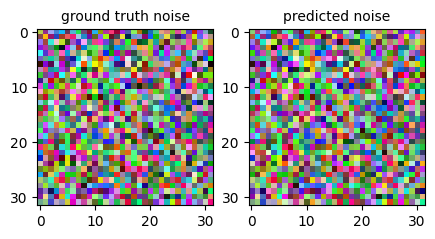

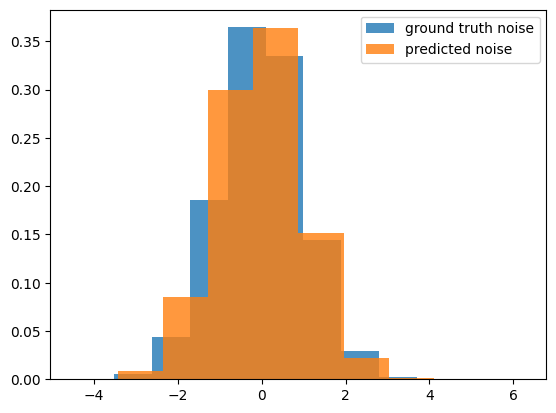

---
Epoch: 750 | Train Loss 0.015213819220662117


<Figure size 1500x1500 with 0 Axes>

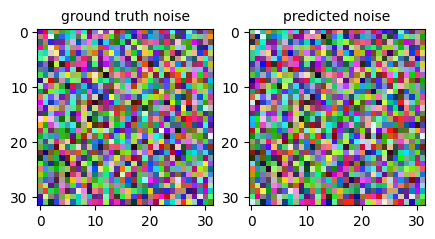

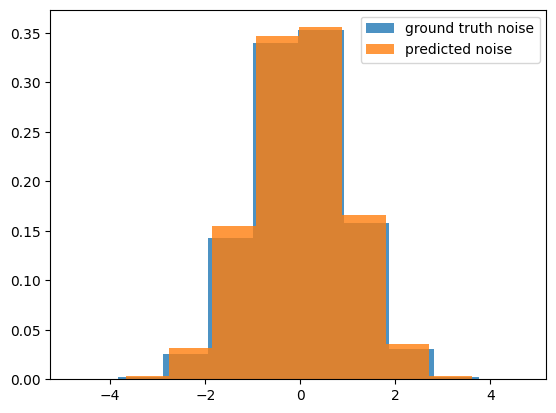

In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_image(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

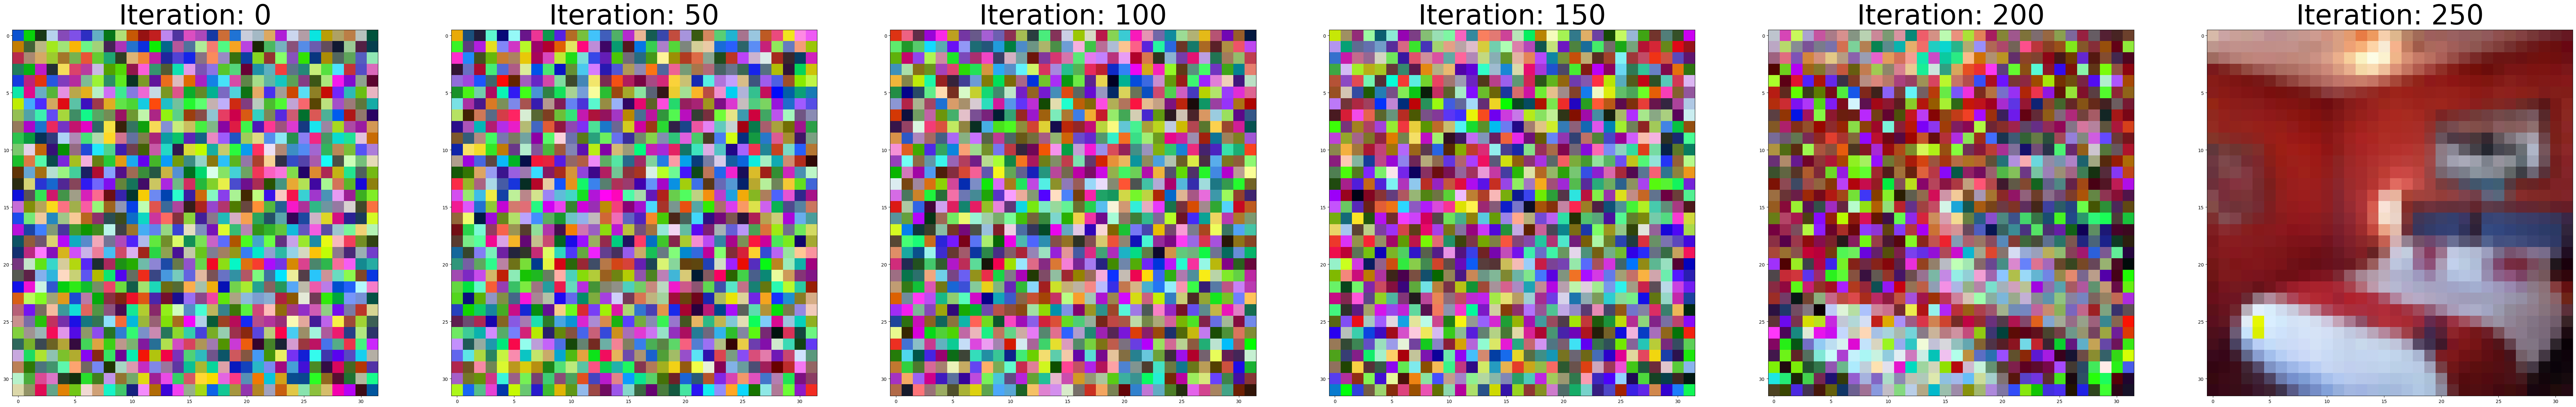

In [ ]:
f, ax = plt.subplots(1, diffusion_model.timesteps//50, figsize = (100,100))

with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    idx=0
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
          ax[idx].imshow(reverse_transform(img[0]))
          ax[idx].set_title(f"Iteration: {idx*50}", fontsize = 60)
          idx+=1

plt.show()

